 FASTTEXT MODEL DEVELOPMENT - DATA LOADING
Loading metadata...
Loaded 15000 documents from metadata

Category distribution:
   • health: 2500 documents
   • sport: 2500 documents
   • technology: 2500 documents
   • economic: 2500 documents
   • politic: 2500 documents
   • environment: 2500 documents

 Loading preprocessed texts from: /Users/socheata/Documents/DEV/preprocessed_articles
   Progress: 1/15000 documents loaded (0.0%)
   Progress: 501/15000 documents loaded (3.3%)
   Progress: 1001/15000 documents loaded (6.7%)
   Progress: 501/15000 documents loaded (3.3%)
   Progress: 1001/15000 documents loaded (6.7%)
   Progress: 1501/15000 documents loaded (10.0%)
   Progress: 2001/15000 documents loaded (13.3%)
   Progress: 1501/15000 documents loaded (10.0%)
   Progress: 2001/15000 documents loaded (13.3%)
   Progress: 2501/15000 documents loaded (16.7%)
   Progress: 3001/15000 documents loaded (20.0%)
   Progress: 3501/15000 documents loaded (23.3%)
   Progress: 2501/15000 document

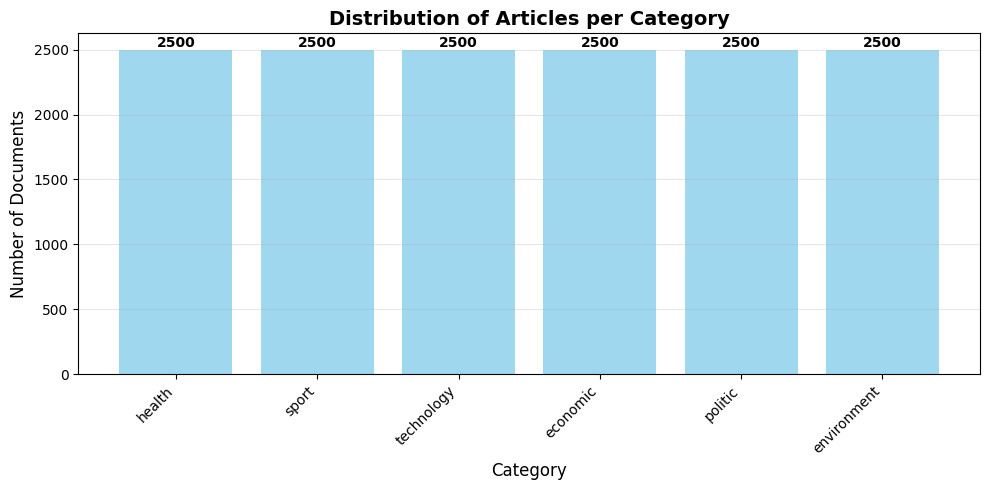


 Creating train-test split (test_size=0.2)...
 Split completed:
   Training set: 11996 documents
   Test set: 3000 documents
   Unique categories in train: 6
   Unique categories in test: 6

 Category distribution in splits:
   • economic: Train=1998, Test=500, Total=2498
   • environment: Train=2000, Test=500, Total=2500
   • health: Train=2000, Test=500, Total=2500
   • politic: Train=1999, Test=500, Total=2499
   • sport: Train=2000, Test=500, Total=2500
   • technology: Train=1999, Test=500, Total=2499

 DATA LOADING SUMMARY:
   Total documents loaded: 14,996
   Number of categories: 6
   Training documents: 11,996
   Test documents: 3,000
   Output directory: /Users/socheata/Documents/DEV/FastText
   Models will be saved to: /Users/socheata/Documents/DEV/FastText/models
   Features will be saved to: /Users/socheata/Documents/DEV/FastText/features

 DATASET STATISTICS:
   • Average document length: 170.0 words
   • Average document length: 170.0 words
   • Minimum document length:

In [1]:
# MODULE 1: SETUP - LIBRARY IMPORTS AND PATH CONFIGURATION
# ============================================================================

# Core Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
import urllib.request
import gzip
import shutil
import time
import json
warnings.filterwarnings('ignore')

# FastText and Gensim
from gensim.models.fasttext import load_facebook_model

# Scikit-learn Libraries
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Utility Libraries
import joblib
from tqdm import tqdm

# Configuration
BASE_DIR = os.getcwd()
PROCESSED_TEXTS_DIR = os.path.join(BASE_DIR, 'preprocessed_articles')
METADATA_PATH = os.path.join(BASE_DIR, 'metadata.csv')
FASTTEXT_MODEL_GZ_PATH = os.path.join(BASE_DIR, 'cc.km.300.bin.gz')
FASTTEXT_MODEL_PATH = os.path.join(BASE_DIR, 'cc.km.300.bin')

# Output directories - all outputs stored in FastText_Results folder
OUTPUT_DIR = os.path.join(BASE_DIR, 'FastText')
MODELS_DIR = os.path.join(OUTPUT_DIR, 'models')
FEATURES_DIR = os.path.join(OUTPUT_DIR, 'features')

# Create output directories
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(FEATURES_DIR, exist_ok=True)

def load_texts_and_labels(metadata_path, processed_texts_dir):
    """Load texts and labels from preprocessed files with detailed progress tracking"""
    print("Loading metadata...")
    
    if not os.path.exists(metadata_path):
        print(f'Metadata file not found: {metadata_path}')
        return None, None, None, None
    
    metadata = pd.read_csv(metadata_path)
    print(f'Loaded {len(metadata)} documents from metadata')
    
    # Display category distribution
    category_counts = metadata['category'].value_counts()
    print('\nCategory distribution:')
    for category, count in category_counts.items():
        print(f'   • {category}: {count} documents')
    
    # Load texts and labels
    print(f'\n Loading preprocessed texts from: {processed_texts_dir}')
    texts = []
    labels = []
    doc_ids = []
    missing_files = 0
    
    total = len(metadata)
    for i, (_, row) in enumerate(metadata.iterrows()):
        # Print progress every 500 documents
        if i % 500 == 0 or i == total - 1:
            print(f"   Progress: {i+1}/{total} documents loaded ({(i+1)/total*100:.1f}%)")
            
        doc_id = row['docId']
        category = row['category']
        file_path = os.path.join(processed_texts_dir, f"{doc_id}.txt")
        
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read().strip()
                    if text:
                        texts.append(text)
                        labels.append(category)
                        doc_ids.append(doc_id)
            except Exception as e:
                print(f"   Error reading {file_path}: {e}")
                missing_files += 1
        else:
            missing_files += 1
    
    print(f'\nSuccessfully loaded {len(texts)} documents')
    if missing_files > 0:
        print(f'   Missing files: {missing_files}')
    
    # Final category distribution
    final_counts = Counter(labels)
    print('\nFinal category distribution:')
    for category, count in final_counts.items():
        print(f'   • {category}: {count} documents')
    
    return texts, labels, doc_ids, metadata

def visualize_category_distribution(metadata):
    """Create category distribution visualization"""
    print("Generating category distribution visualization...")
    
    category_counts = metadata['category'].value_counts()
    
    plt.figure(figsize=(10, 5))
    bars = plt.bar(range(len(category_counts)), category_counts.values, color='skyblue', alpha=0.8)
    plt.title('Distribution of Articles per Category', fontsize=14, fontweight='bold')
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Number of Documents', fontsize=12)
    plt.xticks(range(len(category_counts)), category_counts.index, rotation=45, ha='right')
    
    # Add value labels on top of bars
    for bar, count in zip(bars, category_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5, 
                str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    return category_counts

def create_train_test_split(texts, labels, test_size=0.2, random_state=42):
    """Create stratified train-test split with detailed reporting"""
    print(f"\n Creating train-test split (test_size={test_size})...")
    
    X_train, X_test, y_train, y_test = train_test_split(
        texts, labels, test_size=test_size, random_state=random_state, stratify=labels
    )
    
    print(f' Split completed:')
    print(f'   Training set: {len(X_train)} documents')
    print(f'   Test set: {len(X_test)} documents')
    print(f'   Unique categories in train: {len(set(y_train))}')
    print(f'   Unique categories in test: {len(set(y_test))}')
    
    # Show category distribution in splits
    print(f'\n Category distribution in splits:')
    train_counts = Counter(y_train)
    test_counts = Counter(y_test)
    
    for category in sorted(set(labels)):
        train_count = train_counts.get(category, 0)
        test_count = test_counts.get(category, 0)
        total_count = train_count + test_count
        print(f'   • {category}: Train={train_count}, Test={test_count}, Total={total_count}')
    
    return X_train, X_test, y_train, y_test

# ============================================================================
# DATA LOADING AND PREPARATION
# ============================================================================

print(' FASTTEXT MODEL DEVELOPMENT - DATA LOADING')
print('='*60)

# Load data with enhanced reporting
texts, labels, doc_ids, metadata = load_texts_and_labels(METADATA_PATH, PROCESSED_TEXTS_DIR)

if texts and labels:
    # Visualize category distribution
    category_counts = visualize_category_distribution(metadata)
    
    # Create train-test split
    X_train, X_test, y_train, y_test = create_train_test_split(texts, labels)
    
    print(f'\n DATA LOADING SUMMARY:')
    print('='*40)
    print(f'   Total documents loaded: {len(texts):,}')
    print(f'   Number of categories: {len(set(labels))}')
    print(f'   Training documents: {len(X_train):,}')
    print(f'   Test documents: {len(X_test):,}')
    print(f'   Output directory: {OUTPUT_DIR}')
    print(f'   Models will be saved to: {MODELS_DIR}')
    print(f'   Features will be saved to: {FEATURES_DIR}')
    
    print(f'\n DATASET STATISTICS:')
    print('='*40)
    print(f'   • Average document length: {np.mean([len(text.split()) for text in texts]):.1f} words')
    print(f'   • Minimum document length: {min([len(text.split()) for text in texts])} words')
    print(f'   • Maximum document length: {max([len(text.split()) for text in texts])} words')
    print(f'   • Total vocabulary size: {len(set(" ".join(texts).split())):,} unique words')
    
    print(f'\n SETUP COMPLETED SUCCESSFULLY!')
    print(f' Base directory: {BASE_DIR}')
    print(f' FastText model path: {FASTTEXT_MODEL_PATH}')
    print(f' Ready for FastText feature extraction!')
    print('='*60)
    
else:
    print('Failed to load data!')
    print('='*60)

In [2]:
# MODULE 2: FEATURE EXTRACTION WITH TIMING VISUALIZATION
# ============================================================================

def extract_fasttext_features_with_timing(texts, labels, fasttext_model, method='mean'):
    """Extract FastText features with detailed timing tracking"""
    print(f"\n=== FastText Feature Extraction ({method.upper()} method) ===")
    print(f"Processing {len(texts)} documents...")
    
    # Initialize timing tracking
    category_times = {category: [] for category in set(labels)}
    all_features = []
    extraction_start = time.time()
    
    # Process documents with timing
    for i, (text, label) in enumerate(zip(texts, labels)):
        doc_start = time.time()
        
        # Extract features for this document
        words = text.split()
        if not words:
            # Handle empty documents
            all_features.append(np.zeros(fasttext_model.wv.vector_size))
            continue
            
        # Get word vectors
        word_vectors = []
        for word in words:
            try:
                vector = fasttext_model.wv[word]
                word_vectors.append(vector)
            except KeyError:
                # Handle OOV words
                continue
        
        # Aggregate word vectors
        if word_vectors:
            if method == 'mean':
                doc_vector = np.mean(word_vectors, axis=0)
            elif method == 'sum':
                doc_vector = np.sum(word_vectors, axis=0)
            elif method == 'max':
                doc_vector = np.max(word_vectors, axis=0)
            else:
                doc_vector = np.mean(word_vectors, axis=0)  # Default to mean
        else:
            doc_vector = np.zeros(fasttext_model.wv.vector_size)
        
        all_features.append(doc_vector)
        
        # Track timing per category
        doc_time = time.time() - doc_start
        category_times[label].append(doc_time)
        
        # Progress update
        if (i + 1) % 1000 == 0 or i == len(texts) - 1:
            elapsed = time.time() - extraction_start
            print(f"   Progress: {i+1}/{len(texts)} ({(i+1)/len(texts)*100:.1f}%) - Elapsed: {elapsed:.2f}s")
    
    total_time = time.time() - extraction_start
    print(f"\nFeature extraction completed in {total_time:.2f} seconds")
    
    # Convert to numpy array
    X = np.array(all_features)
    print(f"Feature matrix shape: {X.shape}")
    
    return X, category_times, total_time

def visualize_feature_extraction_timing(category_times, total_time, output_path):
    """Create feature extraction timing visualization with consistent styling"""
    print("\n=== Creating Feature Extraction Timing Visualization ===")
    
    # Calculate statistics
    timing_stats = {}
    for category, times in category_times.items():
        timing_stats[category] = {
            'mean': np.mean(times),
            'std': np.std(times),
            'total': np.sum(times),
            'count': len(times)
        }
    
    # Create visualization with consistent styling from 3A_Model Development
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('FastText Feature Extraction Timing Analysis', fontsize=16, fontweight='bold')
    
    # 1. Average extraction time per category - matching 3A style
    categories = list(timing_stats.keys())
    mean_times = [timing_stats[cat]['mean'] * 1000 for cat in categories]  # Convert to ms
    
    bars1 = ax1.bar(categories, mean_times, color='skyblue', alpha=0.8)
    ax1.set_title('Average Feature Extraction Time per Category', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Time (milliseconds)', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, time_val in zip(bars1, mean_times):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{time_val:.2f}ms', ha='center', va='bottom', fontsize=10)
    
    # 2. Total processing time per category - matching 3A style
    total_times = [timing_stats[cat]['total'] for cat in categories]
    
    bars2 = ax2.bar(categories, total_times, color='skyblue', alpha=0.8)
    ax2.set_title('Total Processing Time per Category', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Time (seconds)', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, time_val in zip(bars2, total_times):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{time_val:.1f}s', ha='center', va='bottom', fontsize=10)
    
    # 3. Document count vs processing time scatter - matching 3A style
    doc_counts = [timing_stats[cat]['count'] for cat in categories]
    
    bars3 = ax3.bar(categories, doc_counts, color='skyblue', alpha=0.8)
    ax3.set_title('Number of Documents per Category', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Category', fontsize=12)
    ax3.set_ylabel('Number of Documents', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, count in zip(bars3, doc_counts):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(doc_counts)*0.01,
                f'{count:,}', ha='center', va='bottom', fontsize=10)
    
    # 4. Summary statistics table - matching 3A style
    ax4.axis('tight')
    ax4.axis('off')
    
    # Create table data
    table_data = []
    for cat in categories:
        stats = timing_stats[cat]
        table_data.append([
            cat,
            f"{stats['count']:,}",
            f"{stats['mean']*1000:.2f}ms",
            f"{stats['total']:.1f}s"
        ])
    
    # Add total row
    total_docs = sum(timing_stats[cat]['count'] for cat in categories)
    avg_time_per_doc = total_time / total_docs if total_docs > 0 else 0
    table_data.append([
        'TOTAL',
        f"{total_docs:,}",
        f"{avg_time_per_doc*1000:.2f}ms",
        f"{total_time:.1f}s"
    ])
    
    table = ax4.table(cellText=table_data,
                     colLabels=['Category', 'Documents', 'Avg Time', 'Total Time'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax4.set_title('Feature Extraction Summary Statistics', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Timing visualization saved to: {output_path}")
    plt.show()
    
    return timing_stats

In [3]:
# MODULE 3: FEATURE SAVING AND STATISTICS
# ============================================================================

def save_fasttext_features(X_train, X_test, y_train, y_test, features_dir):
    """Save FastText features and statistics"""
    print("\n=== Saving FastText Features ===")
    
    # Save feature arrays
    train_features_path = os.path.join(features_dir, 'X_train_fasttext.joblib')
    test_features_path = os.path.join(features_dir, 'X_test_fasttext.joblib')
    train_labels_path = os.path.join(features_dir, 'y_train_fasttext.joblib')
    test_labels_path = os.path.join(features_dir, 'y_test_fasttext.joblib')
    
    joblib.dump(X_train, train_features_path)
    joblib.dump(X_test, test_features_path)
    joblib.dump(y_train, train_labels_path)
    joblib.dump(y_test, test_labels_path)
    
    print(f"✓ Training features saved: {train_features_path}")
    print(f"✓ Test features saved: {test_features_path}")
    print(f"✓ Training labels saved: {train_labels_path}")
    print(f"✓ Test labels saved: {test_labels_path}")
    
    # Calculate and save feature statistics
    feature_stats = {
        'feature_count': X_train.shape[1],
        'train_samples': X_train.shape[0],
        'test_samples': X_test.shape[0],
        'feature_type': 'fasttext_mean_embeddings',
        'feature_range': {
            'min': float(np.min(X_train)),
            'max': float(np.max(X_train)),
            'mean': float(np.mean(X_train)),
            'std': float(np.std(X_train))
        }
    }
    
    stats_path = os.path.join(features_dir, 'feature_statistics.json')
    with open(stats_path, 'w') as f:
        json.dump(feature_stats, f, indent=4)
    
    print(f"✓ Feature statistics saved: {stats_path}")
    print(f"   - Feature dimensions: {X_train.shape[1]}")
    print(f"   - Training samples: {X_train.shape[0]}")
    print(f"   - Test samples: {X_test.shape[0]}")
    print(f"   - Feature range: [{feature_stats['feature_range']['min']:.4f}, {feature_stats['feature_range']['max']:.4f}]")
    
    return feature_stats

🚀 Starting FastText Model Development...
Loading metadata...
Loaded 15000 documents from metadata

Category distribution:
   • health: 2500 documents
   • sport: 2500 documents
   • technology: 2500 documents
   • economic: 2500 documents
   • politic: 2500 documents
   • environment: 2500 documents

 Loading preprocessed texts from: /Users/socheata/Documents/DEV/preprocessed_articles
   Progress: 1/15000 documents loaded (0.0%)
   Progress: 501/15000 documents loaded (3.3%)
   Progress: 1001/15000 documents loaded (6.7%)
   Progress: 1501/15000 documents loaded (10.0%)
   Progress: 2001/15000 documents loaded (13.3%)
   Progress: 2501/15000 documents loaded (16.7%)
   Progress: 3001/15000 documents loaded (20.0%)
   Progress: 3001/15000 documents loaded (20.0%)
   Progress: 3501/15000 documents loaded (23.3%)
   Progress: 4001/15000 documents loaded (26.7%)
   Progress: 4501/15000 documents loaded (30.0%)
   Progress: 5001/15000 documents loaded (33.3%)
   Progress: 5501/15000 documen

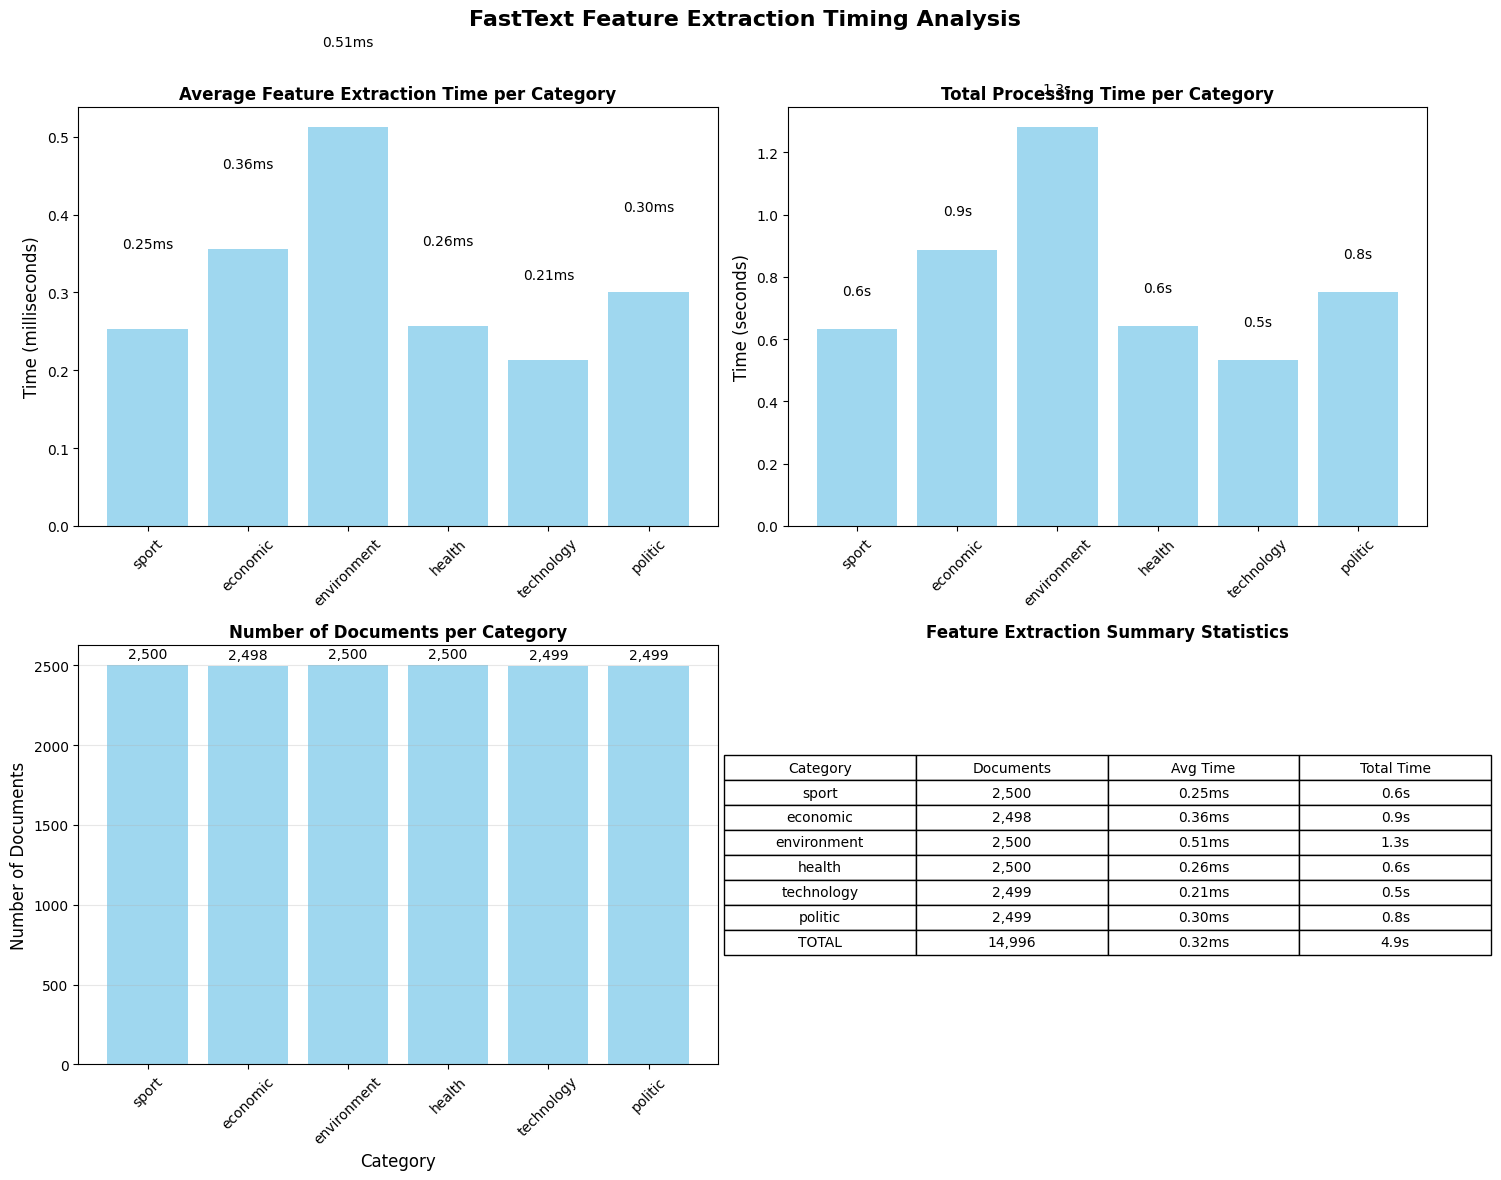


=== Saving FastText Features ===
✓ Training features saved: /Users/socheata/Documents/DEV/FastText/features/X_train_fasttext.joblib
✓ Test features saved: /Users/socheata/Documents/DEV/FastText/features/X_test_fasttext.joblib
✓ Training labels saved: /Users/socheata/Documents/DEV/FastText/features/y_train_fasttext.joblib
✓ Test labels saved: /Users/socheata/Documents/DEV/FastText/features/y_test_fasttext.joblib
✓ Feature statistics saved: /Users/socheata/Documents/DEV/FastText/features/feature_statistics.json
   - Feature dimensions: 300
   - Training samples: 11996
   - Test samples: 3000
   - Feature range: [-0.4816, 0.8350]

🎯 Ready for model training!


In [4]:
# MODULE 4: MAIN EXECUTION - DATA LOADING AND FEATURE EXTRACTION
# ============================================================================

# Load data
print('🚀 Starting FastText Model Development...')
print('='*60)

# Load texts and labels
texts, labels, doc_ids, metadata = load_texts_and_labels(METADATA_PATH, PROCESSED_TEXTS_DIR)

if texts is None or labels is None:
    print('❌ Error: Could not load data')
else:
    print(f'✅ Successfully loaded {len(texts)} documents')
    
    # Create train-test split
    X_train, X_test, y_train, y_test = create_train_test_split(texts, labels)
    
    # Load FastText model
    print('\n🤖 Loading FastText model...')
    try:
        from gensim.models.fasttext import load_facebook_model
        fasttext_model = load_facebook_model(FASTTEXT_MODEL_PATH)
        print(f'✅ FastText model loaded successfully!')
        print(f'   Vector size: {fasttext_model.wv.vector_size}')
        print(f'   Vocabulary size: {len(fasttext_model.wv.key_to_index)}')
        
        # Extract features with timing
        X_train_features, train_category_times, train_time = extract_fasttext_features_with_timing(
            X_train, y_train, fasttext_model, method='mean')
        X_test_features, test_category_times, test_time = extract_fasttext_features_with_timing(
            X_test, y_test, fasttext_model, method='mean')
        
        print(f'\n✅ Feature extraction completed!')
        print(f'   Training features shape: {X_train_features.shape}')
        print(f'   Test features shape: {X_test_features.shape}')
        print(f'   Total extraction time: {train_time + test_time:.2f}s')
        
        # Combine timing data for visualization
        all_category_times = {}
        for category in set(y_train + y_test):
            all_category_times[category] = (
                train_category_times.get(category, []) + 
                test_category_times.get(category, []))
        
        # Create timing visualization
        timing_viz_path = os.path.join(FEATURES_DIR, 'feature_extraction_time_visualization.png')
        timing_stats = visualize_feature_extraction_timing(
            all_category_times, train_time + test_time, timing_viz_path)
        
        # Save features and statistics
        feature_stats = save_fasttext_features(
            X_train_features, X_test_features, y_train, y_test, FEATURES_DIR)
        
        print('\n🎯 Ready for model training!')
        
    except Exception as e:
        print(f'❌ Error loading FastText model: {str(e)}')
        print('   Please ensure cc.km.300.bin is in the current directory')
        X_train_features = None
        X_test_features = None

In [5]:
# MODULE 4B: LOAD PRE-SAVED FEATURES FOR MODEL TRAINING
# ============================================================================

def load_features_from_joblib():
    """Load pre-saved features from joblib files"""
    print('\n🔄 Loading features from joblib files...')
    
    try:
        # Load feature arrays
        X_train_path = os.path.join(FEATURES_DIR, 'X_train_fasttext.joblib')
        X_test_path = os.path.join(FEATURES_DIR, 'X_test_fasttext.joblib')
        y_train_path = os.path.join(FEATURES_DIR, 'y_train_fasttext.joblib')
        y_test_path = os.path.join(FEATURES_DIR, 'y_test_fasttext.joblib')
        
        # Check if all files exist
        if not all(os.path.exists(path) for path in [X_train_path, X_test_path, y_train_path, y_test_path]):
            print('❌ Feature files not found. Available files:')
            for path in [X_train_path, X_test_path, y_train_path, y_test_path]:
                status = '✅' if os.path.exists(path) else '❌'
                print(f'   {status} {os.path.basename(path)}')
            print('   Please run the feature extraction section first.')
            return None, None, None, None
        
        # Load features
        print('   Loading feature arrays...')
        X_train_features = joblib.load(X_train_path)
        X_test_features = joblib.load(X_test_path)
        y_train = joblib.load(y_train_path)
        y_test = joblib.load(y_test_path)
        
        print(f'✅ Features loaded successfully!')
        print(f'   Training features shape: {X_train_features.shape}')
        print(f'   Test features shape: {X_test_features.shape}')
        print(f'   Training labels: {len(y_train)} samples')
        print(f'   Test labels: {len(y_test)} samples')
        print(f'   Unique categories: {sorted(set(y_train))}')
        
        return X_train_features, X_test_features, y_train, y_test
        
    except Exception as e:
        print(f'❌ Error loading features: {str(e)}')
        return None, None, None, None

# Load features from saved joblib files
print('='*70)
print('💾 LOADING PRE-SAVED FEATURES FOR MODEL TRAINING')
print('='*70)

X_train_features, X_test_features, y_train, y_test = load_features_from_joblib()

if X_train_features is not None:
    # Get unique categories for both SVM and MNB training
    categories = sorted(list(set(y_test)))
    print(f'\n🎯 Ready for model training with {len(categories)} categories!')
    print(f'   Categories: {categories}')
else:
    print('\n⚠️ Cannot proceed with model training without features.')
    print('   Please run the feature extraction section first.')

💾 LOADING PRE-SAVED FEATURES FOR MODEL TRAINING

🔄 Loading features from joblib files...
   Loading feature arrays...
✅ Features loaded successfully!
   Training features shape: (11996, 300)
   Test features shape: (3000, 300)
   Training labels: 11996 samples
   Test labels: 3000 samples
   Unique categories: ['economic', 'environment', 'health', 'politic', 'sport', 'technology']

🎯 Ready for model training with 6 categories!
   Categories: ['economic', 'environment', 'health', 'politic', 'sport', 'technology']



🛠️ MODULE 5: SVM TRAINING
Using pre-loaded FastText features...
🏅 Training SVM with FastText features...
📈 Using 300 features

🔧 Training SVM with pipeline...
✅ SVM results:
   📈 Test Accuracy: 0.9100
   📈 Test F1-Score: 0.9100
   🔄 CV Accuracy: 0.9104 (±0.0023)
   ⏱️ Training Time: 47.88 seconds

📊 Creating essential visualizations...
Creating SVM learning curve visualization...
✅ SVM results:
   📈 Test Accuracy: 0.9100
   📈 Test F1-Score: 0.9100
   🔄 CV Accuracy: 0.9104 (±0.0023)
   ⏱️ Training Time: 47.88 seconds

📊 Creating essential visualizations...
Creating SVM learning curve visualization...


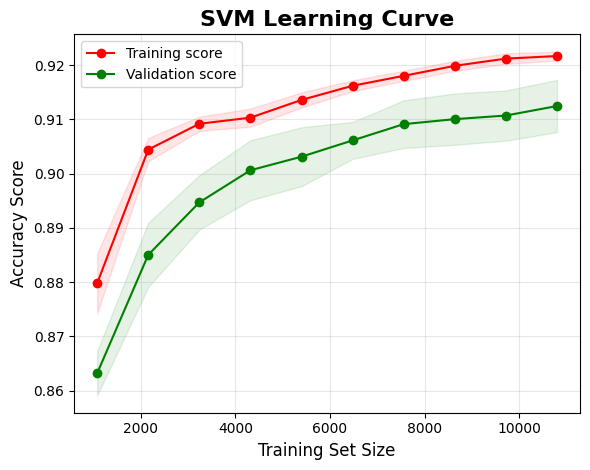

   Learning curve saved to: /Users/socheata/Documents/DEV/FastText/models/svm_learning_curve.png
Creating SVM confusion matrix visualization...


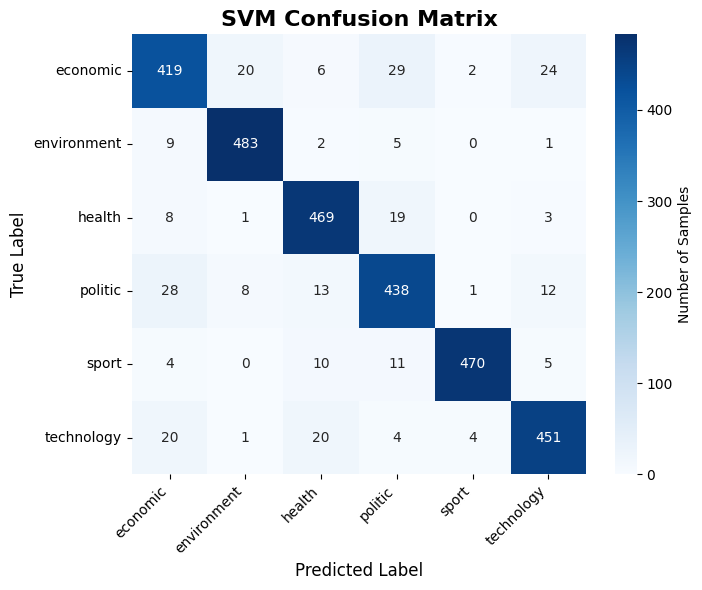

   Confusion matrix saved to: /Users/socheata/Documents/DEV/FastText/models/svm_confusion_matrix.png
Performing SVM error analysis...
   Error analysis saved to: /Users/socheata/Documents/DEV/FastText/models/svm_error_analysis.txt

   Categories with Highest Error Rates:
     economic: 16.20% error rate (419/500 correctly classified)
     politic: 12.40% error rate (438/500 correctly classified)
     technology: 9.80% error rate (451/500 correctly classified)
     health: 6.20% error rate (469/500 correctly classified)
     sport: 6.00% error rate (470/500 correctly classified)
Generating SVM classification report...
   Classification report saved to: /Users/socheata/Documents/DEV/FastText/models/svm_classification_report.txt

💾 SVM model saved to: /Users/socheata/Documents/DEV/FastText/models/svm_model.joblib
Model information saved to: /Users/socheata/Documents/DEV/FastText/models/svm_model_info.txt

🏆 SVM TRAINING COMPLETE
📈 Test Accuracy: 0.9100 (91.0%)
📈 Test F1-Score: 0.9100
🔄 CV

In [6]:
# MODULE 5: SVM TRAINING
# ============================================================================

def train_svm_model():
    """Train and evaluate SVM classifier with FastText features"""
    if 'X_train_features' not in globals() or 'X_test_features' not in globals():
        print('❌ Features not available')
        return None
    
    print('🏅 Training SVM with FastText features...')
    print(f'📈 Using {X_train_features.shape[1]} features')
    
    from sklearn.svm import SVC
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.model_selection import cross_val_score
    import time
    
    # Create pipeline with StandardScaler and SVM
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(
            C=0.1,                    
            class_weight='balanced',   
            probability=True,         
            random_state=42,          
            kernel='rbf',             
            gamma='scale'             
        ))
    ])
    
    
    print('\n🔧 Training SVM with pipeline...')
    start_time = time.time()
    
    try:
        # Train the model
        pipeline.fit(X_train_features, y_train)
        training_time = time.time() - start_time
        
        # Make predictions
        y_pred = pipeline.predict(X_test_features)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Training and validation accuracy
        train_accuracy = pipeline.score(X_train_features, y_train)
        
        # Cross-validation score
        cv_scores = cross_val_score(pipeline, X_train_features, y_train, cv=5, scoring='accuracy')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        # Calculate overfitting gap
        overfitting_gap = train_accuracy - accuracy
        
        svm_results = {
            'pipeline': pipeline,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'train_accuracy': train_accuracy,
            'validation_accuracy': cv_mean,
            'cv_mean': cv_mean,
            'cv_std': cv_std,
            'training_time': training_time,
            'overfitting_gap': overfitting_gap,
            'y_pred': y_pred
        }
        
        print(f'✅ SVM results:')
        print(f'   📈 Test Accuracy: {accuracy:.4f}')
        print(f'   📈 Test F1-Score: {f1:.4f}')
        print(f'   🔄 CV Accuracy: {cv_mean:.4f} (±{cv_std:.4f})')
        print(f'   ⏱️ Training Time: {training_time:.2f} seconds')
        
        return svm_results
        
    except Exception as e:
        print(f'❌ Error training SVM: {str(e)}')
        return None

def create_svm_confusion_matrix(y_test, y_pred, categories, output_dir):
    """Create confusion matrix visualization for SVM - matching 3A_Model Development style"""
    print("Creating SVM confusion matrix visualization...")
    
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Import to avoid any naming conflicts
    import sklearn.metrics
    
    # Create confusion matrix using full module path - matching 3A style
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred, labels=categories)
    
    # Create visualization - matching 3A_Model Development exact styling
    plt.figure(figsize=(7.2, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=categories, yticklabels=categories,
                cbar_kws={'label': 'Number of Samples'})
    
    plt.title('SVM Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save visualization
    filename = 'svm_confusion_matrix.png'
    cm_path = os.path.join(output_dir, filename)
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"   Confusion matrix saved to: {cm_path}")
    
    return cm

def perform_svm_error_analysis(y_test, y_pred, categories, output_dir):
    """Perform error analysis for SVM"""
    print("Performing SVM error analysis...")
    
    # Find misclassified samples
    misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) 
                            if true != pred]
    
    # Group errors by category
    errors_by_category = {}
    for i in misclassified_indices:
        true_category = y_test[i]
        pred_category = y_pred[i]
        if true_category not in errors_by_category:
            errors_by_category[true_category] = []
        errors_by_category[true_category].append(pred_category)
    
    # Calculate error rates
    error_rates = {}
    for category in categories:
        total_count = sum(1 for y in y_test if y == category)
        error_count = len(errors_by_category.get(category, []))
        error_rates[category] = error_count / total_count if total_count > 0 else 0
    
    # Save error analysis
    error_analysis_path = os.path.join(output_dir, 'svm_error_analysis.txt')
    with open(error_analysis_path, 'w', encoding='utf-8') as f:
        f.write("SVM Error Analysis\n")
        f.write("="*40 + "\n\n")
        f.write(f"Total test samples: {len(y_test)}\n")
        f.write(f"Misclassified samples: {len(misclassified_indices)}\n")
        f.write(f"Overall error rate: {len(misclassified_indices)/len(y_test)*100:.2f}%\n\n")
        
        f.write("Error Rates by Category:\n")
        f.write("-"*30 + "\n")
        sorted_categories = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)
        for category, error_rate in sorted_categories:
            correct_count = sum(1 for y in y_test if y == category) - len(errors_by_category.get(category, []))
            total_count = sum(1 for y in y_test if y == category)
            f.write(f"{category}: {error_rate:.2%} error rate ({correct_count}/{total_count} correctly classified)\n")
        
        # Common confusion pairs
        confusion_pairs = {}
        for true_category, errors in errors_by_category.items():
            for pred_category in errors:
                pair = (true_category, pred_category)
                confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1
        
        f.write("\nMost Common Misclassification Pairs:\n")
        f.write("-"*40 + "\n")
        sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)
        for (true_cat, pred_cat), count in sorted_pairs[:10]:
            f.write(f"{true_cat} -> {pred_cat}: {count} instances\n")
    
    print(f"   Error analysis saved to: {error_analysis_path}")
    
    # Display top categories with highest error rates
    print("\n   Categories with Highest Error Rates:")
    for category, error_rate in sorted_categories[:5]:
        correct_count = sum(1 for y in y_test if y == category) - len(errors_by_category.get(category, []))
        total_count = sum(1 for y in y_test if y == category)
        print(f"     {category}: {error_rate:.2%} error rate ({correct_count}/{total_count} correctly classified)")

def save_svm_classification_report(y_test, y_pred, categories, output_dir):
    """Generate and save SVM classification report"""
    print("Generating SVM classification report...")
    
    from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
    import numpy as np
    
    # Generate classification report
    class_report = classification_report(y_test, y_pred, target_names=categories, digits=4)
    
    # Save to file
    filename = 'svm_classification_report.txt'
    report_path = os.path.join(output_dir, filename)
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("SVM Classification Report\n")
        f.write("="*40 + "\n\n")
        f.write(class_report)
        f.write("\n\n")
        
        # Add per-class metrics
        f.write("Per-Class Metrics Summary:\n")
        f.write("-"*30 + "\n")
        
        for category in categories:
            category_mask = np.array(y_test) == category
            if np.sum(category_mask) > 0:
                category_pred = np.array(y_pred)[category_mask]
                category_true = np.array(y_test)[category_mask]
                
                precision = precision_score(category_true, category_pred, labels=[category], average='macro')
                recall = recall_score(category_true, category_pred, labels=[category], average='macro')
                f1 = f1_score(category_true, category_pred, labels=[category], average='macro')
                
                f.write(f"{category}:\n")
                f.write(f"  Precision: {precision:.4f}\n")
                f.write(f"  Recall: {recall:.4f}\n")
                f.write(f"  F1-Score: {f1:.4f}\n")
                f.write(f"  Support: {np.sum(category_mask)}\n\n")
    
    print(f"   Classification report saved to: {report_path}")

def create_learning_curve_visualization(model, X_train, y_train, output_dir, model_name, cv_folds=10):
    """Create learning curve visualization matching 3A_Model Development style"""
    print(f"Creating {model_name} learning curve visualization...")
    
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    
    try:
        # Define training sizes - matching 3A style
        train_sizes = np.linspace(0.1, 1.0, 10)
        
        # Compute learning curve - matching 3A parameters
        train_sizes_abs, train_scores, val_scores = learning_curve(
            model,
            X_train,
            y_train,
            train_sizes=train_sizes,
            cv=cv_folds,
            scoring='accuracy',  # Changed from f1_weighted to accuracy to match 3A
            n_jobs=-1,
            random_state=42
        )
        
        # Calculate mean and standard deviation
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        # Plot learning curve - matching 3A_Model Development exact styling
        plt.figure(figsize=(6, 4.8))
        plt.plot(train_sizes_abs, train_mean, 'o-', color='r', label='Training score')
        plt.plot(train_sizes_abs, val_mean, 'o-', color='g', label='Validation score')
        plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
        plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
        
        plt.title(f'{model_name} Learning Curve', fontsize=16, fontweight='bold')
        plt.xlabel('Training Set Size', fontsize=12)
        plt.ylabel('Accuracy Score', fontsize=12)
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Save visualization
        filename = f'{model_name.lower()}_learning_curve.png'
        lc_path = os.path.join(output_dir, filename)
        plt.savefig(lc_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"   Learning curve saved to: {lc_path}")
        
        return {
            'train_sizes': train_sizes_abs,
            'train_scores': train_scores,
            'val_scores': val_scores
        }
    
    except Exception as e:
        print(f"   Warning: Could not generate learning curve. Error: {e}")
        return None

if X_train_features is not None:
    print('\n🛠️ MODULE 5: SVM TRAINING')
    print('='*50)
    print('Using pre-loaded FastText features...')
    
    # Train SVM
    svm_results = train_svm_model()
    
    if svm_results:
        # Create essential visualizations only
        print('\n📊 Creating essential visualizations...')
        
        # 1. Learning curve visualization
        create_learning_curve_visualization(
            svm_results['pipeline'],  # Use full pipeline
            X_train_features,         # Use pre-loaded features
            y_train, 
            MODELS_DIR, 
            'SVM', 
            cv_folds=10
        )
        
        # 2. Confusion matrix visualization
        create_svm_confusion_matrix(
            y_test, svm_results['y_pred'], categories, MODELS_DIR
        )
        
        # 3. Error analysis
        perform_svm_error_analysis(y_test, svm_results['y_pred'], categories, MODELS_DIR)
        
        # 4. Classification report
        save_svm_classification_report(y_test, svm_results['y_pred'], categories, MODELS_DIR)
        
        # Save the trained model (pipeline)
        model_filename = 'svm_model.joblib'
        model_path = os.path.join(MODELS_DIR, model_filename)
        joblib.dump(svm_results['pipeline'], model_path)
        
        print(f"\n💾 SVM model saved to: {model_path}")
        
        # Create model info file
        info_filename = 'svm_model_info.txt'
        info_path = os.path.join(MODELS_DIR, info_filename)
        
        with open(info_path, 'w', encoding='utf-8') as f:
            f.write(f"SVM Model Information\n")
            f.write("="*60 + "\n\n")
            f.write(f"Pipeline: StandardScaler + SVM\n")
            f.write(f"Model Type: Support Vector Machine (RBF kernel)\n")
            f.write(f"Parameters: C=0.1, gamma=scale, class_weight=balanced, probability=True\n")
            f.write(f"Feature Engineering: FastText mean embeddings\n")
            f.write(f"Feature Count: {X_train_features.shape[1]}\n")
            f.write(f"Training Samples: {len(y_train)}\n")
            f.write(f"Test Samples: {len(y_test)}\n")
            f.write(f"Training Time: {svm_results['training_time']:.2f} seconds\n")
            f.write(f"Training Accuracy: {svm_results['train_accuracy']:.4f}\n")
            f.write(f"Validation Accuracy: {svm_results['validation_accuracy']:.4f}\n")
            f.write(f"Test Accuracy: {svm_results['accuracy']:.4f}\n")
            f.write(f"Test F1-Score: {svm_results['f1_score']:.4f}\n")
            f.write(f"Test Precision: {svm_results['precision']:.4f}\n")
            f.write(f"Test Recall: {svm_results['recall']:.4f}\n")
            f.write(f"Overfitting Gap: {svm_results['overfitting_gap']:.4f}\n")
            f.write(f"CV Mean: {svm_results['cv_mean']:.4f}\n")
            f.write(f"CV Std: {svm_results['cv_std']:.4f}\n")
        
        print(f"Model information saved to: {info_path}")
        
        # Summary
        print("\n" + "="*60)
        print("🏆 SVM TRAINING COMPLETE")
        print("="*60)
        print(f"📈 Test Accuracy: {svm_results['accuracy']:.4f} ({svm_results['accuracy']*100:.1f}%)")
        print(f"📈 Test F1-Score: {svm_results['f1_score']:.4f}")
        print(f"🔄 CV Accuracy: {svm_results['cv_mean']:.4f} (±{svm_results['cv_std']:.4f})")
        print(f"⏱️ Training Time: {svm_results['training_time']:.2f} seconds")
        
        print(f"\n💾 Essential Files Generated:")
        print(f"   • Model: svm_model.joblib")
        print(f"   • Info: svm_model_info.txt")
        print(f"   • Learning Curve: svm_learning_curve.png")
        print(f"   • Confusion Matrix: svm_confusion_matrix.png")
        print(f"   • Classification Report: svm_classification_report.txt")
        print(f"   • Error Analysis: svm_error_analysis.txt")
        
        print("="*60)
    
else:
    print('❌ Cannot train SVM: Features not available')
    print('   Please run the feature extraction section first')


🛠️ MODULE 6: MNB TRAINING
Using pre-loaded features from joblib files...
🏅 Training Multinomial Naive Bayes with FastText features...
📈 Using 300 features

🔧 Training Multinomial Naive Bayes...

Using pre-loaded features from joblib files...
🏅 Training Multinomial Naive Bayes with FastText features...
📈 Using 300 features

🔧 Training Multinomial Naive Bayes...
✅ MNB results:
   📈 Test Accuracy: 0.8493
   📈 Test F1-Score: 0.8490
   🔄 CV F1: 0.8607 (±0.0046)

📊 Creating essential MNB visualizations...
Creating MNB learning curve visualization...
✅ MNB results:
   📈 Test Accuracy: 0.8493
   📈 Test F1-Score: 0.8490
   🔄 CV F1: 0.8607 (±0.0046)

📊 Creating essential MNB visualizations...
Creating MNB learning curve visualization...


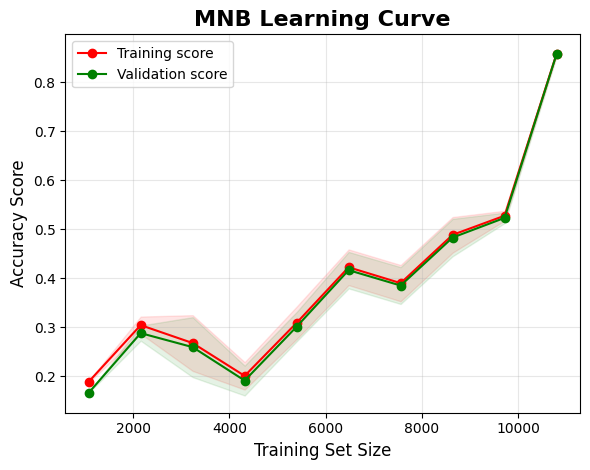

   Learning curve saved to: /Users/socheata/Documents/DEV/FastText/models/mnb_learning_curve.png
Creating MNB confusion matrix visualization...


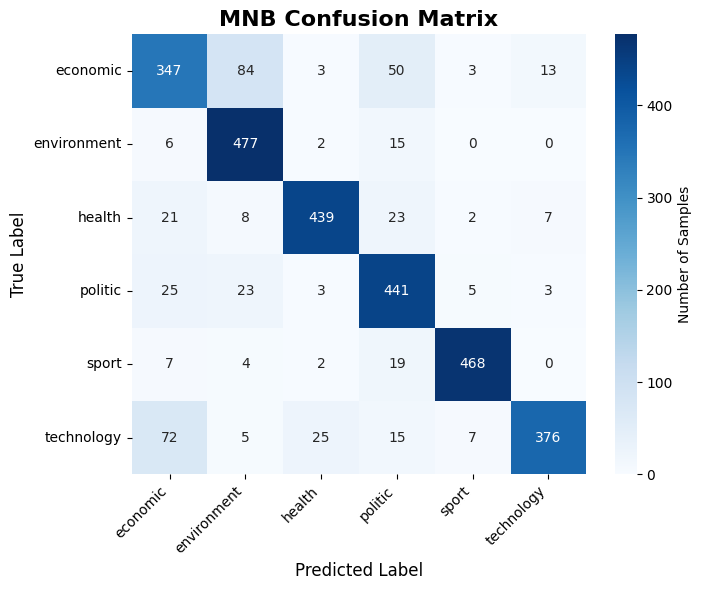

   Confusion matrix saved to: /Users/socheata/Documents/DEV/FastText/models/mnb_confusion_matrix.png
Performing MNB error analysis...
   Error analysis saved to: /Users/socheata/Documents/DEV/FastText/models/mnb_error_analysis.txt

   Categories with Highest Error Rates:
     economic: 30.60% error rate (347/500 correctly classified)
     technology: 24.80% error rate (376/500 correctly classified)
     health: 12.20% error rate (439/500 correctly classified)
     politic: 11.80% error rate (441/500 correctly classified)
     sport: 6.40% error rate (468/500 correctly classified)
Generating MNB classification report...
   Classification report saved to: /Users/socheata/Documents/DEV/FastText/models/mnb_classification_report.txt

MNB model saved to: /Users/socheata/Documents/DEV/FastText/models/mnb_model.joblib
Model information saved to: /Users/socheata/Documents/DEV/FastText/models/mnb_model_info.txt

🏆 MNB TRAINING COMPLETE
📈 Test Accuracy: 0.8493 (84.9%)
📈 Test F1-Score: 0.8490
🔄 CV

In [7]:
# MODULE 6: MNB TRAINING
# ============================================================================

def train_mnb_model():
    """Train and evaluate Multinomial Naive Bayes classifier with FastText features"""
    if 'X_train_features' not in globals() or 'X_test_features' not in globals():
        print('❌ Features not available')
        return None
    
    print('🏅 Training Multinomial Naive Bayes with FastText features...')
    print(f'📈 Using {X_train_features.shape[1]} features')
    
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.model_selection import cross_val_score
    import numpy as np
    
    # MNB requires non-negative features, so shift the data
    X_train_shifted = X_train_features - X_train_features.min() + 0.01
    X_test_shifted = X_test_features - X_test_features.min() + 0.01
    
    # Initialize and train MNB
    mnb_model = MultinomialNB()
    
    print('\n🔧 Training Multinomial Naive Bayes...')
    
    try:
        mnb_model.fit(X_train_shifted, y_train)
        y_pred = mnb_model.predict(X_test_shifted)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Cross-validation score
        cv_scores = cross_val_score(mnb_model, X_train_shifted, y_train, cv=10, scoring='f1_weighted')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        mnb_results = {
            'model': mnb_model,
            'X_train_shifted': X_train_shifted,
            'X_test_shifted': X_test_shifted,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'cv_f1_mean': cv_mean,
            'cv_f1_std': cv_std,
            'y_pred': y_pred
        }
        
        print(f'✅ MNB results:')
        print(f'   📈 Test Accuracy: {accuracy:.4f}')
        print(f'   📈 Test F1-Score: {f1:.4f}')
        print(f'   🔄 CV F1: {cv_mean:.4f} (±{cv_std:.4f})')
        
        return mnb_results
        
    except Exception as e:
        print(f'❌ Error training MNB: {str(e)}')
        return None

def create_mnb_confusion_matrix(y_test, y_pred, categories, output_dir):
    """Create confusion matrix visualization for MNB - matching 3A_Model Development style"""
    print("Creating MNB confusion matrix visualization...")
    
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Import to avoid any naming conflicts
    import sklearn.metrics
    
    # Create confusion matrix using full module path - matching 3A style
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred, labels=categories)
    
    # Create visualization - matching 3A_Model Development exact styling
    plt.figure(figsize=(7.2, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=categories, yticklabels=categories,
                cbar_kws={'label': 'Number of Samples'})
    
    plt.title('MNB Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save visualization
    filename = 'mnb_confusion_matrix.png'
    cm_path = os.path.join(output_dir, filename)
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"   Confusion matrix saved to: {cm_path}")
    
    return cm

def perform_mnb_error_analysis(y_test, y_pred, categories, output_dir):
    """Perform error analysis for MNB"""
    print("Performing MNB error analysis...")
    
    # Find misclassified samples
    misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) 
                            if true != pred]
    
    # Group errors by category
    errors_by_category = {}
    for i in misclassified_indices:
        true_category = y_test[i]
        pred_category = y_pred[i]
        if true_category not in errors_by_category:
            errors_by_category[true_category] = []
        errors_by_category[true_category].append(pred_category)
    
    # Calculate error rates
    error_rates = {}
    for category in categories:
        total_count = sum(1 for y in y_test if y == category)
        error_count = len(errors_by_category.get(category, []))
        error_rates[category] = error_count / total_count if total_count > 0 else 0
    
    # Save error analysis
    error_analysis_path = os.path.join(output_dir, 'mnb_error_analysis.txt')
    with open(error_analysis_path, 'w', encoding='utf-8') as f:
        f.write("MNB Error Analysis\n")
        f.write("="*40 + "\n\n")
        f.write(f"Total test samples: {len(y_test)}\n")
        f.write(f"Misclassified samples: {len(misclassified_indices)}\n")
        f.write(f"Overall error rate: {len(misclassified_indices)/len(y_test)*100:.2f}%\n\n")
        
        f.write("Error Rates by Category:\n")
        f.write("-"*30 + "\n")
        sorted_categories = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)
        for category, error_rate in sorted_categories:
            correct_count = sum(1 for y in y_test if y == category) - len(errors_by_category.get(category, []))
            total_count = sum(1 for y in y_test if y == category)
            f.write(f"{category}: {error_rate:.2%} error rate ({correct_count}/{total_count} correctly classified)\n")
        
        # Common confusion pairs
        confusion_pairs = {}
        for true_category, errors in errors_by_category.items():
            for pred_category in errors:
                pair = (true_category, pred_category)
                confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1
        
        f.write("\nMost Common Misclassification Pairs:\n")
        f.write("-"*40 + "\n")
        sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)
        for (true_cat, pred_cat), count in sorted_pairs[:10]:
            f.write(f"{true_cat} -> {pred_cat}: {count} instances\n")
    
    print(f"   Error analysis saved to: {error_analysis_path}")
    
    # Display top categories with highest error rates
    print("\n   Categories with Highest Error Rates:")
    for category, error_rate in sorted_categories[:5]:
        correct_count = sum(1 for y in y_test if y == category) - len(errors_by_category.get(category, []))
        total_count = sum(1 for y in y_test if y == category)
        print(f"     {category}: {error_rate:.2%} error rate ({correct_count}/{total_count} correctly classified)")

def save_mnb_classification_report(y_test, y_pred, categories, output_dir):
    """Generate and save MNB classification report"""
    print("Generating MNB classification report...")
    
    from sklearn.metrics import classification_report
    import numpy as np
    
    # Generate classification report
    class_report = classification_report(y_test, y_pred, target_names=categories, digits=4)
    
    # Save to file
    filename = 'mnb_classification_report.txt'
    report_path = os.path.join(output_dir, filename)
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("MNB Classification Report\n")
        f.write("="*40 + "\n\n")
        f.write(class_report)
        f.write("\n\n")
        
        # Add per-class metrics
        f.write("Per-Class Metrics Summary:\n")
        f.write("-"*30 + "\n")
        
        for category in categories:
            category_mask = np.array(y_test) == category
            if np.sum(category_mask) > 0:
                category_pred = np.array(y_pred)[category_mask]
                category_true = np.array(y_test)[category_mask]
                
                precision = precision_score(category_true, category_pred, labels=[category], average='macro')
                recall = recall_score(category_true, category_pred, labels=[category], average='macro')
                f1 = f1_score(category_true, category_pred, labels=[category], average='macro')
                
                f.write(f"{category}:\n")
                f.write(f"  Precision: {precision:.4f}\n")
                f.write(f"  Recall: {recall:.4f}\n")
                f.write(f"  F1-Score: {f1:.4f}\n")
                f.write(f"  Support: {np.sum(category_mask)}\n\n")
    
    print(f"   Classification report saved to: {report_path}")

def create_learning_curve_visualization(model, X_train, y_train, output_dir, model_name, cv_folds=10):
    """Create learning curve visualization matching 3A_Model Development style"""
    print(f"Creating {model_name} learning curve visualization...")
    
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    
    try:
        # Define training sizes - matching 3A style
        train_sizes = np.linspace(0.1, 1.0, 10)
        
        # Compute learning curve - matching 3A parameters
        train_sizes_abs, train_scores, val_scores = learning_curve(
            model,
            X_train,
            y_train,
            train_sizes=train_sizes,
            cv=cv_folds,
            scoring='accuracy',  # Changed from f1_weighted to accuracy to match 3A
            n_jobs=-1,
            random_state=42
        )
        
        # Calculate mean and standard deviation
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        # Plot learning curve - matching 3A_Model Development exact styling
        plt.figure(figsize=(6, 4.8))
        plt.plot(train_sizes_abs, train_mean, 'o-', color='r', label='Training score')
        plt.plot(train_sizes_abs, val_mean, 'o-', color='g', label='Validation score')
        plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
        plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
        
        plt.title(f'{model_name} Learning Curve', fontsize=16, fontweight='bold')
        plt.xlabel('Training Set Size', fontsize=12)
        plt.ylabel('Accuracy Score', fontsize=12)
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Save visualization
        filename = f'{model_name.lower()}_learning_curve.png'
        lc_path = os.path.join(output_dir, filename)
        plt.savefig(lc_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"   Learning curve saved to: {lc_path}")
        
        return {
            'train_sizes': train_sizes_abs,
            'train_scores': train_scores,
            'val_scores': val_scores
        }
    
    except Exception as e:
        print(f"   Warning: Could not generate learning curve. Error: {e}")
        return None

# MNB Training Execution
# ----------------------------------------------------------------------------

# Use the same features loaded for SVM training
if X_train_features is not None and X_test_features is not None:
    print('\n🛠️ MODULE 6: MNB TRAINING')
    print('='*50)
    print('Using pre-loaded features from joblib files...')
    
    # Train MNB
    mnb_results = train_mnb_model()
    
    if mnb_results:
        # Create essential visualizations only
        print('\n📊 Creating essential MNB visualizations...')
        
        # 1. Learning curve visualization
        create_learning_curve_visualization(
            mnb_results['model'],
            mnb_results['X_train_shifted'],
            y_train,
            MODELS_DIR,
            'MNB',
            cv_folds=10
        )
        
        # 2. Confusion matrix visualization
        create_mnb_confusion_matrix(
            y_test, mnb_results['y_pred'], categories, MODELS_DIR
        )
        
        # 3. Error analysis
        perform_mnb_error_analysis(y_test, mnb_results['y_pred'], categories, MODELS_DIR)
        
        # 4. Classification report
        save_mnb_classification_report(y_test, mnb_results['y_pred'], categories, MODELS_DIR)
        
        # Save the trained model
        model_filename = 'mnb_model.joblib'
        model_path = os.path.join(MODELS_DIR, model_filename)
        joblib.dump(mnb_results['model'], model_path)
        
        print(f"\nMNB model saved to: {model_path}")
        
        # Create model info file
        info_filename = 'mnb_model_info.txt'
        info_path = os.path.join(MODELS_DIR, info_filename)
        
        with open(info_path, 'w', encoding='utf-8') as f:
            f.write(f"MNB Model Information\n")
            f.write("="*60 + "\n\n")
            f.write(f"Model Type: Multinomial Naive Bayes\n")
            f.write(f"Feature Engineering: FastText mean embeddings (shifted for non-negativity)\n")
            f.write(f"Feature Count: {X_train_features.shape[1]}\n")
            f.write(f"Training Samples: {len(y_train)}\n")
            f.write(f"Test Samples: {len(y_test)}\n")
            f.write(f"Test Accuracy: {mnb_results['accuracy']:.4f}\n")
            f.write(f"Test F1-Score: {mnb_results['f1_score']:.4f}\n")
            f.write(f"Test Precision: {mnb_results['precision']:.4f}\n")
            f.write(f"Test Recall: {mnb_results['recall']:.4f}\n")
            f.write(f"CV F1 Mean: {mnb_results['cv_f1_mean']:.4f}\n")
            f.write(f"CV F1 Std: {mnb_results['cv_f1_std']:.4f}\n")
        
        print(f"Model information saved to: {info_path}")
        
        # Summary
        print("\n" + "="*60)
        print("🏆 MNB TRAINING COMPLETE")
        print("="*60)
        print(f"📈 Test Accuracy: {mnb_results['accuracy']:.4f} ({mnb_results['accuracy']*100:.1f}%)")
        print(f"📈 Test F1-Score: {mnb_results['f1_score']:.4f}")
        print(f"🔄 CV F1: {mnb_results['cv_f1_mean']:.4f} (±{mnb_results['cv_f1_std']:.4f})")
        
        print(f"\n💾 Essential Files Generated:")
        print(f"   • Model: mnb_model.joblib")
        print(f"   • Info: mnb_model_info.txt")
        print(f"   • Learning Curve: mnb_learning_curve.png")
        print(f"   • Confusion Matrix: mnb_confusion_matrix.png")
        print(f"   • Classification Report: mnb_classification_report.txt")
        print(f"   • Error Analysis: mnb_error_analysis.txt")
        
        print("="*60)
    
else:
    print('❌ Cannot train MNB: Features not available')
    print('   Please run the feature extraction section first')